<a href="https://colab.research.google.com/github/shahedmomenzadeh/generative_models_journey/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# --- Configuration Class ---
class VAEConfig:
    def __init__(self):
        self.latent_dim = 20        # Dimensionality of the latent space
        self.loss_type = 'BCE'      # Choose 'BCE' or 'MSE'
        self.beta = 1.0             # Beta parameter for KL divergence weighting
        self.batch_size = 128
        self.epochs = 15
        self.learning_rate = 1e-3
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = VAEConfig()

# --- Dataset and DataLoader ---
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=500, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 606kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]


In [2]:
class VAE(nn.Module):
    def __init__(self, config):
        super(VAE, self).__init__()
        self.latent_dim = config.latent_dim

        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc2_mu = nn.Linear(400, self.latent_dim)
        self.fc2_logvar = nn.Linear(400, self.latent_dim)

        # Decoder
        self.fc3 = nn.Linear(self.latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        # We keep Sigmoid even for MSE to ensure outputs are valid pixel values [0, 1]
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE(config).to(config.device)

In [3]:
def calculate_loss(recon_x, x, mu, logvar, config):
    # 1. Reconstruction Loss
    if config.loss_type == 'BCE':
        recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    elif config.loss_type == 'MSE':
        recon_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    else:
        raise ValueError("Invalid loss_type. Choose 'BCE' or 'MSE'.")

    # 2. KL Divergence
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # 3. Total Loss with Beta weighting
    return recon_loss + (config.beta * kld_loss)

In [4]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

print(f"Training VAE with {config.loss_type} loss and latent dimension {config.latent_dim}...")

model.train()
for epoch in range(config.epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(config.device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = calculate_loss(recon_batch, data, mu, logvar, config)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{config.epochs}], Average Loss: {avg_loss:.4f}")

Training VAE with BCE loss and latent dimension 20...
Epoch [1/15], Average Loss: 164.7874
Epoch [2/15], Average Loss: 121.6226
Epoch [3/15], Average Loss: 114.6667
Epoch [4/15], Average Loss: 111.6887
Epoch [5/15], Average Loss: 110.0282
Epoch [6/15], Average Loss: 108.9023
Epoch [7/15], Average Loss: 108.0880
Epoch [8/15], Average Loss: 107.4939
Epoch [9/15], Average Loss: 106.9298
Epoch [10/15], Average Loss: 106.5320
Epoch [11/15], Average Loss: 106.1472
Epoch [12/15], Average Loss: 105.8890
Epoch [13/15], Average Loss: 105.6131
Epoch [14/15], Average Loss: 105.3353
Epoch [15/15], Average Loss: 105.0907


Running t-SNE (this may take a few moments)...


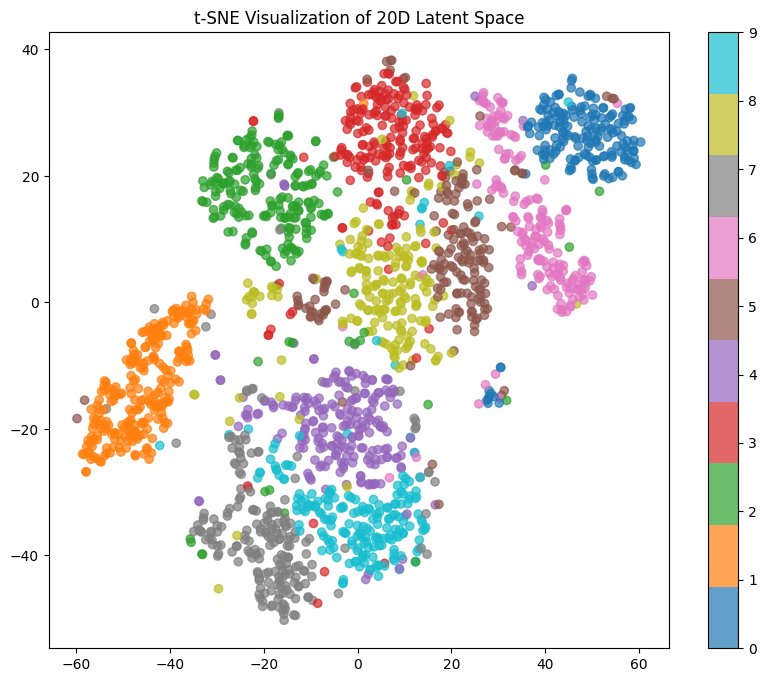

In [5]:
def plot_tsne_latent_space(model, dataloader, config, num_samples=2000):
    model.eval()
    z_points = []
    labels = []

    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(config.device)
            mu, _ = model.encode(data.view(-1, 784))
            z_points.append(mu.cpu().numpy())
            labels.append(label.numpy())

            # Stop gathering data once we hit our sample limit
            if len(np.concatenate(z_points)) >= num_samples:
                break

    z_points = np.concatenate(z_points, axis=0)[:num_samples]
    labels = np.concatenate(labels, axis=0)[:num_samples]

    print("Running t-SNE (this may take a few moments)...")
    tsne = TSNE(n_components=2, random_state=42)
    z_2d = tsne.fit_transform(z_points)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(f"t-SNE Visualization of {config.latent_dim}D Latent Space")
    plt.show()

plot_tsne_latent_space(model, test_loader, config)

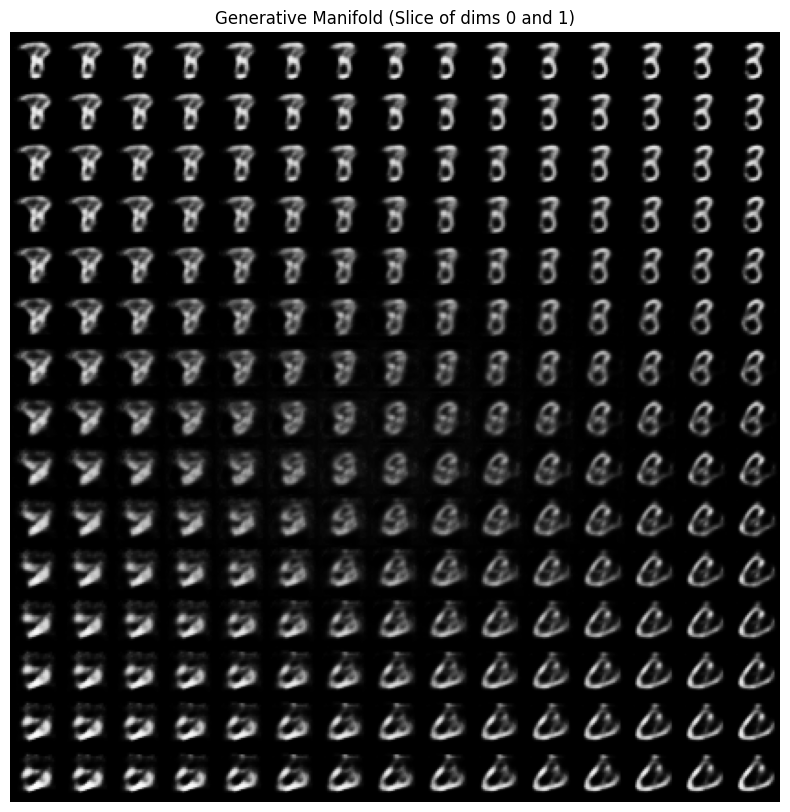

In [6]:
def plot_manifold_slice(model, config, grid_size=15, bound=2.5):
    model.eval()
    x_coords = np.linspace(-bound, bound, grid_size)
    y_coords = np.linspace(bound, -bound, grid_size)

    figure = np.zeros((28 * grid_size, 28 * grid_size))

    with torch.no_grad():
        for i, yi in enumerate(y_coords):
            for j, xi in enumerate(x_coords):
                # Create a zero vector for all dimensions
                z = torch.zeros(1, config.latent_dim).to(config.device)

                # Vary only the first two dimensions
                z[0, 0] = xi
                z[0, 1] = yi

                # Decode the vector into an image
                generated_image = model.decode(z).cpu().view(28, 28).numpy()
                figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = generated_image

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.axis('off')
    plt.title(f"Generative Manifold (Slice of dims 0 and 1)")
    plt.show()

plot_manifold_slice(model, config)